In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import font_manager
import os

sns.set(rc={'figure.figsize':(6.5, 4.5)})
sns.set_theme(style='white')

font_path='./cmunss.ttf'
if os.path.exists(font_path):
    font_manager.fontManager.addfont(font_path)
    prop = font_manager.FontProperties(fname=font_path)
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'axes.labelsize': '16', 'axes.labelpad': '8.0', 'axes.titlesize':'4'})
plt.rcParams['axes.unicode_minus'] = False

plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
# plt.rcParams["legend.markerscale"] = 10.0
# plt.rcParams['lines.markersize'] = 10

In [2]:
import pandas as pd

df = pd.read_csv('results.csv', sep='\t', header=None)
df.columns = ['path', 'test', 'prompt', 'score']

In [3]:
df_lora = pd.read_csv('lora_variations.csv', sep='\t', header=None)
df_lora.columns = ['path', 'test', 'prompt', 'score']

In [4]:
df = df[df['path'].apply(lambda x: 'gpt2_TweetData' in x and '10_8_0.0005' in x)]

In [5]:
df_full = pd.concat([df, df_lora])

In [6]:
import numpy as np

df_full['score'] = df_full['score'].apply(lambda x: np.array(eval(x)))

In [7]:
def mean(x):
    return np.mean(x)

df_avg = df_full.groupby(['path', 'test']).agg({'score': mean}).reset_index()

In [8]:
from utils import parse_path

def path_cols(row):
    path = row['path']

    cols, vals = parse_path(path)

    for col, val in zip(cols, vals):
        row[col] = val
    
    return row

df_avg = df_avg.apply(path_cols, axis=1)

/home/ericwallace/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
def score_cols(row, score_names: list[str]):
    score = row['score']

    for i, name in enumerate(score_names):
        row[name] = score[i]
    
    return row

test_name = 'MBTI_Extroversion'
score_names = ['Extroverted', 'Sensing', 'Thinking', 'Judging']
df_test = df_avg[df_avg['test'] == test_name]

df_test = df_test.apply(score_cols, axis=1, score_names=score_names)

df_test = df_test.melt(id_vars=['data', 'r', 'alpha', 'epochs', 'batch_size', 'lr', 'num_steps'], value_vars=score_names, var_name='score', value_name='value')

In [10]:
df_test = df_test[df_test['num_steps'] == 1510]

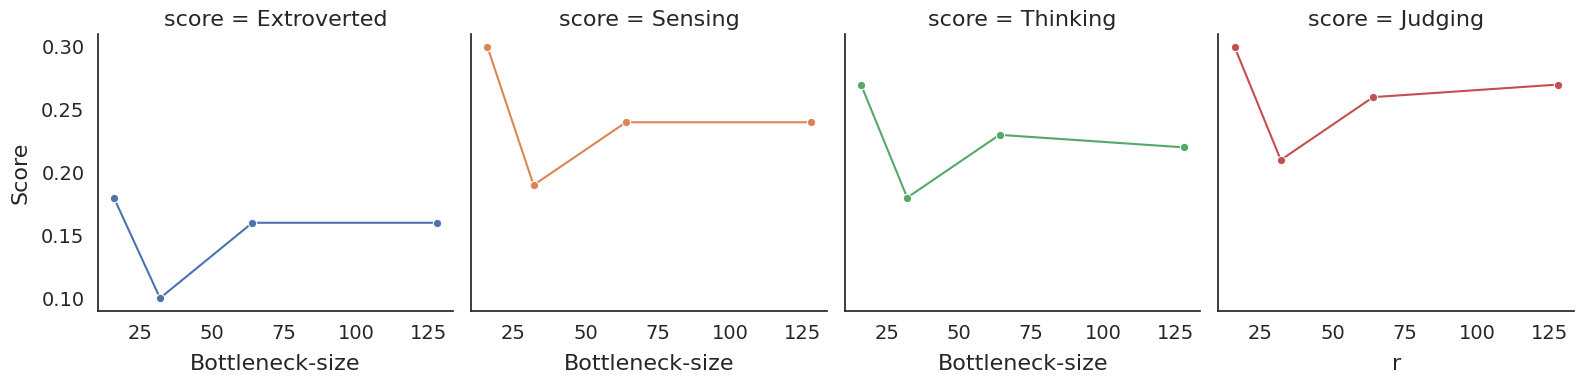

In [11]:
import seaborn as sns
from matplotlib import pyplot as plt

grid = sns.FacetGrid(df_test, col='score', hue='score', height=4, aspect=1.0)

grid.map_dataframe(
    sns.lineplot,
    x='r',
    y='value',
    marker='o'
)

for i in range(3):
    ax = grid.axes[-1, i]
    ax.set_xlabel('Bottleneck-size')

grid.axes[0,0].set_ylabel('Score')

plt.savefig('figs/bottleneck_variation.pdf', bbox_inches='tight')
plt.show()